In [16]:
import tensorflow as tf
import os
import tensorflow_addons as tfa
import numpy as np
import time
from beaker_kmer_generator import KmerGenerator as kmer_generator
from biobeaker.utils import get_angles, positional_encoding
from biobeaker import BEAKER
from tensorflow.keras.layers import Dense, Embedding, Flatten, Lambda, Subtract, Input, Concatenate, AveragePooling1D, LocallyConnected1D, Conv1D, GaussianNoise, BatchNormalization, Reshape, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Model, Sequential
import pandas as pd
import plotly.express as px
import scipy.stats

In [2]:
# Hyper parameters
k = 21
window_size = 32
num_layers = 8
embedding_dims = 32
output_dims = 128 # Output dims are also internal dims!
intermediate_dims = 256
num_heads = 8
dropout_rate = 0.15
max_positions = 512
batch_size = 128

In [3]:
magic = Dense(embedding_dims, 
                activation=tf.nn.swish, 
                name="Magic", 
                use_bias=False, 
                trainable=False,
                dtype=tf.float32)

magic.build((window_size+1,k*5))

#Load up the weights
weights = np.load("../../precomputed/weights_wide_singlelayer_k21_3Aug2020model_21_dims_32_epochs256.npy", allow_pickle=True)
magic.set_weights([weights[0][0]])

2022-06-21 11:51:54.507347: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-21 11:51:54.508485: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-21 11:51:54.539784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:42:00.0 name: NVIDIA GeForce GTX 1070 Ti computeCapability: 6.1
coreClock: 1.683GHz coreCount: 19 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 238.66GiB/s
2022-06-21 11:51:54.539829: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-06-21 11:51:54.543366: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-06-21 11:51:54.543437: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.s

In [4]:
def gen():
    kg = kmer_generator()
    kg.set_threads(2)
    kg.set_k(k)
    kg.set_seed(42)
    kg.start()
    while True:
        data = kg.generate_pairs()
        for i in data:
            (k1a, k2a, score) = i
            yield (k1a, k2a, score)

In [5]:
kgen = gen()
(k1, k2, score) = next(kgen)

In [6]:
def calc_magic_score(k1, k2):
    out = magic(np.asarray([k1, k2]))
    return np.sum(abs(out[0] - out[1]))

In [7]:
calc_magic_score(k1, k2)

18.301727

In [12]:
y_true = list()
y = list()

for _ in range(20000):
    (k1, k2, score) = next(kgen)
    y.append(calc_magic_score(k1, k2))
    y_true.append(score)
    

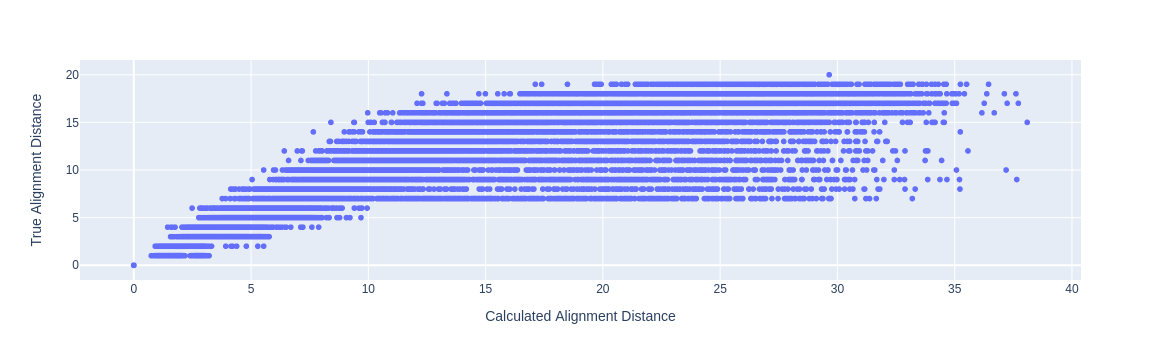

In [28]:
fig = px.scatter(y=y_true, x=y, 
           labels={
                     "y": "True Alignment Distance",
                     "x": "Calculated Alignment Distance",
                 },)

fig.write_image("alignment_vs_calculated.png", width=800, height=400)

fig

In [24]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y, y_true)
np.square(r_value)

0.7584339505096023

In [19]:
r_value

0.8708811345468463

In [20]:
p_value

0.0

In [21]:
slope

0.5496744796460259

In [22]:
np.corrcoef(y, y_true)

array([[1.        , 0.87088113],
       [0.87088113, 1.        ]])

0.7584339505096023